# Paquetería necesaria

In [1]:
using PyPlot
using Interact
using LaTeXStrings

# Variables requeridas

In [56]:
function Inicializar_variables(k)
    global L=k
    global caracterizacion = "WL2D_triangular_L_$(L)_Is_ferr_cam_10_f_0.0001"
    println(caracterizacion)
    global datos, cabecera = readdlm("Entropia_2D_final/Entropia_2D_final_$(caracterizacion).txt", header=true)
    global temp_inicial = 0.4
    global temp_final = 8
    global δtemp = 0.1
    global temperatura = (temp_inicial:δtemp:temp_final)
    global β = 1./temperatura
    global h_inicial = 0.0
    global h_final = 4.0
    global δh = 0.2
    global h = (h_inicial:δh:h_final)
    global card_β = length(β)
    global card_h = length(h)
    global l = size(datos)[1]
    global constante_de_renormalización = [0.0 for i in 1:card_β, j in 1:card_h]
    global energía_promedio = [0.0 for i in 1:card_β, j in 1:card_h];
    global magnetización_promedio = [0.0 for i in 1:card_β, j in 1:card_h]
    global parámetro_de_orden_promedio = [0.0 for i in 1:card_β, j in 1:card_h]
    global capacidad_calorífica = [0.0 for i in 1:card_β, j in 1:card_h]
    global susceptibilidad_magnética = [0.0 for i in 1:card_β, j in 1:card_h];
end

Inicializar_variables (generic function with 1 method)

In [57]:
Inicializar_variables(9);

WL2D_triangular_L_9_Is_ferr_cam_10_f_0.0001


# Datos de entropía exacta, si la hay

Los archivos de la entropía exacta tienen la siguiente configuración

***1a Columna***: Valor de la entropía

***2a Columna***: Energía

***3a Columna***: Magnetización

In [394]:
exact = readdlm("ising_c16xc16.txt");

In [400]:
# En caso de que se trate de interacción antiferromagnética, se multiplica por -1.
exact[:,2]=exact[:,2]*(-1);

In [403]:
#reordenar por energía(segunda columna) y luego por magnetización (3a columna).
exact = sortrows(exact, by=x->(x[2],x[3]));

# Definiendo funciones

## Gráficas de entropía experimental y teórica con animación

In [381]:
function Grafica3d(angle,x,y,z)
    plot3D(x,y,z, ".", alpha=0.2 )
        ax = gca()
        ax[:view_init](elev=30., azim=angle)
end

Grafica3d (generic function with 1 method)

In [382]:
function Animar_grafica3d(x,y,z)
    fig = figure(figsize=(8,6))
    @manipulate for angle=0:10:360
        withfig(fig) do
            Grafica3d(angle,x,y,z)
        end
    end
end 

Animar_grafica3d (generic function with 1 method)

In [405]:
function Grafica3d_teórica(angle,x,y,z)
    plot3D(x, y, log(z), "o", alpha=0.2 )
    ax = gca()
    ax[:view_init](elev=30., azim=angle)
end

Grafica3d_teórica (generic function with 2 methods)

### Comparar restando, entropía teórica y entropía experimental

In [407]:
function Compara_entropias(x,y,z1,z2)
    fig = figure(figsize=(8,6))
    @manipulate for angle=0:10:360
        withfig(fig) do
            plot3D(x, y, z1-log(z2), "o", alpha=0.2 )
            ax = gca()
                ax[:view_init](elev=30., azim=angle)
        end
    end
end

Compara_entropias (generic function with 1 method)

## Funciones para  obtener observables

In [379]:
function Renormalizar(i,j)
    for k in 1:l
        if constante_de_renormalización[i,j]<=datos[k,3]-β[i]*(datos[k,1]-h[j]*datos[k,2])
            constante_de_renormalización[i,j]=datos[k,3]-β[i]*(datos[k,1]-h[j]*datos[k,2])
        end
    end
end 

Renormalizar (generic function with 1 method)

In [380]:
function Rellenar_matriz_de_renormalización()
    for i=1:card_β 
        for j=1:card_h
            Renormalizar(i,j)
        end
    end
end

Rellenar_matriz_de_renormalización (generic function with 1 method)

In [384]:
function Variables_Macroscópicas(i,j)
    función_de_partición_1D = 0.0
    función_de_partición_2D = 0.0
    energía = 0.0
    energía_cuadrada = 0.0
    magnetización = 0.0
    magnetización_cuadrada = 0.0
    parámetro_de_orden = 0.0
    exponente = 0.0
    for k in 1:l
        exponente = datos[k,3] - β[i]*(datos[k,1]-h[j]*datos[k,2]) - constante_de_renormalización[i,j]
        función_de_partición_2D += exp(exponente)
        energía += abs(datos[k,1])*exp(exponente)
        energía_cuadrada += datos[k,1]*datos[k,1]*exp(exponente)
        magnetización += abs(datos[k,2])*exp(exponente)
        magnetización_cuadrada += datos[k,2]*datos[k,2]*exp(exponente)
        parámetro_de_orden += abs(datos[k,4])*exp(exponente)
    end
    energía_promedio[i,j] = (energía)/(función_de_partición_2D*L)
    magnetización_promedio[i,j] = (magnetización)/(función_de_partición_2D*L)
    parámetro_de_orden_promedio[i,j] = (parámetro_de_orden)/(función_de_partición_2D*L)
    capacidad_calorífica[i,j] = abs(energía_cuadrada - energía*energía)/(función_de_partición_2D*L*L)
    susceptibilidad_magnética[i,j] = abs(magnetización_cuadrada - magnetización*magnetización)/(función_de_partición_2D*L*L)
end

Variables_Macroscópicas (generic function with 1 method)

In [385]:
function Obtener_variables_macroscópicas()
    for i=1:card_β
        for j=1:card_h
            Variables_Macroscópicas(i,j)
        end
    end
end

Obtener_variables_macroscópicas (generic function with 1 method)

## Gáficas de observables

In [415]:
function Mostrar_varias_observables()
    fig = figure()
    @manipulate for i in 1:card_h
        withfig(fig) do
            subplot(221)
            ylim(0,1.05)
            xlabel("Temperatura")
            ylabel("P.O.")
            plot(temperatura,parámetro_de_orden_promedio[:,i], label = latexstring("h=$(h[i])"))
            legend()
            subplot(222)
            xlabel("Temperatura")
            ylabel("Energía")
            plot(temperatura,energía_promedio[:,i], label = latexstring("h=$(h[i])"))
            legend()
            subplot(223)
            xlabel("Temperatura")
            ylabel("Capacidad calorífica")
            plot(temperatura,capacidad_calorífica[:,i], label = latexstring("h=$(h[i])"))
            legend()
            subplot(224)
            xlabel("Temperatura")
            ylabel("Susceptibilidad magnética")
            plot(temperatura,susceptibilidad_magnética[:,i], label = latexstring("h=$(h[i])"))
            legend()
        end
    end
end

Mostrar_varias_observables (generic function with 1 method)

## Gráfica de observables vs temperatura con $h$ fija

ARGUMENTOS DE LA FUNCIÓN:

***observables_macroscópicas***: conjunto de valores de la observable para cada valor de temperatura

***cadena***: Nombre del eje Y

In [428]:
function Grafica_observable_macroscópica_con_h_fija(valor_de_h,observable_macroscópica, cadena)
    xlabel("Temperatura")
    ylabel(cadena)
    title(cadena)
    plot(temperatura,observable_macroscópica, label = latexstring(L"h="*"$(valor_de_h)"))
    legend()
end

Grafica_observable_macroscópica_con_h_fija (generic function with 2 methods)

## Gráfica de observable vs temperatura para varias $h$'s 

In [392]:
function Grafica_varias_observables_para_distintos_h(observable_macroscópica, cadena)
    for i in 1:card_β
        ylim(0,1.05)
        plot(temperatura,observable_macroscópica[:,i],label = latexstring("h=$(h[i])"))
        #legend (loc="upper right")
        xlabel("Temperatura")
        ylabel(cadena)
        title(cadena*" en función de "*L"h")
        legend(loc=1, borderaxespad=-8.)
    end
end

Grafica_varias_observables_para_distintos_h (generic function with 1 method)

## Graficar observable para varias $L$'s, para encontrar exponentes y temperaturas críticas

In [433]:
function Graficar_variando_parámetros()    
    fig = figure(figsize=(6,6))
    @manipulate for i=1:1:card_β, γ=1:.5:10, ν=1:.5:10
        withfig(fig) do
            for k in 1:2
                plot((temperatura[i:end]-temperatura[i])*(L_vec[k])^(1/ν), (observables[k][i:end,6])*(L_vec[k])^(-γ/ν))
#            plot((temperatura[i:end]-temperatura[i])*12^(1/ν), (datos2[i:end,6])*12^(-γ/ν))
            end
        end
    end
end

Graficar_variando_parámetros (generic function with 3 methods)

## Parámetro de orden 3D, como función de $\beta$ y $h$

In [ ]:
function Parámetro_de_orden_3D()    
    fig = figure(figsize=(5,4))
    @manipulate for angle=0:10:360
        withfig(fig) do
            surf(temperatura, h, magnetización_promedio', alpha=0.4, rstride=3, cstride=3)
            ax = gca()
            ax[:view_init](elev=30., azim=angle)
            xlabel(L"T")
            ylabel(L"h")
            zlabel(L"M(T,h)")
        end
    end

## Obtener resultados para varias $L$'s 

In [434]:
function analizar_varios_L(L_vec)
    for i in L_vec
        Inicializar_variables(i)
        Rellenar_matriz_de_renormalización()
        Obtener_variables_macroscópicas()        
        #println(energía_promedio[:,1])
        push!(observables, [temperatura energía_promedio[:,1] magnetización_promedio[:,1] parámetro_de_orden_promedio[:,1] capacidad_calorífica[:,1] susceptibilidad_magnética[:,1] ])
        #writedlm("Observables_$L", Observables)        
    end
end

analizar_varios_L (generic function with 1 method)

# Aquí acaban las funciones

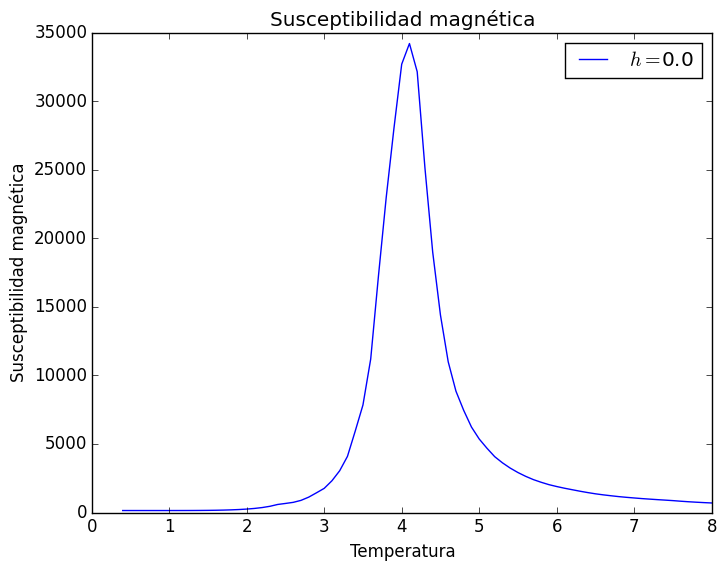

In [432]:
i=1
Grafica_observable_macroscópica_con_h_fija(h[i],susceptibilidad_magnética[:,i],"Susceptibilidad magnética");

In [417]:
Mostrar_varias_observables();

Interact.Slider{Int64}(Signal{Int64}(11, nactions=0),"i",11,1:21,true)

# REALIZAR ANÁLISIS

In [368]:
L_vec = [9,12]
observables = Array[]

0-element Array{Array{T,N},1}

In [409]:
analizar_varios_L(L_vec)

WL2D_triangular_L_9_Is_ferr_cam_10_f_0.0001
WL2D_triangular_L_12_Is_ferr_cam_10_f_0.0001


Interact.Slider{Int64}(Signal{Int64}(39, nactions=0),"i",39,1:1:77,true)

Interact.Slider{Float64}(Signal{Float64}(5.5, nactions=0),"γ",5.5,1.0:0.5:10.0,true)

Interact.Slider{Float64}(Signal{Float64}(5.5, nactions=0),"ν",5.5,1.0:0.5:10.0,true)

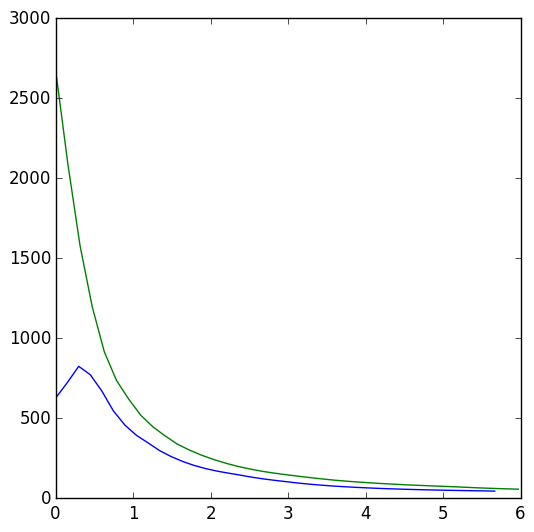

In [374]:
Graficar_variando_parámetros()